In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
%matplotlib inline

In [5]:
def f(x):
  return 3*x**2 - 4*x + 5

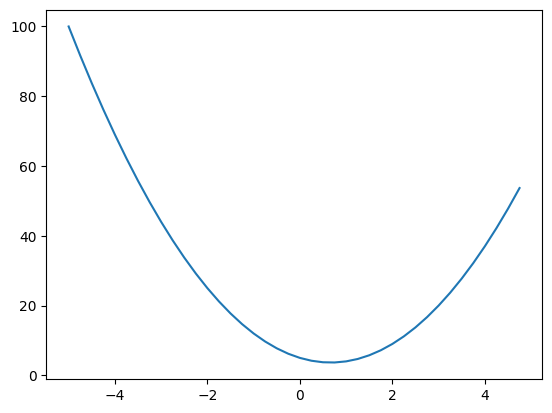

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [7]:
h = 0.00001
x = 2/3
(f(x+h)-f(x))/h

3.0000002482211127e-05

In [8]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [9]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [149]:
class Value: 
    def __init__(self,data,_chilren=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_chilren)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self * other
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/float"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += other*(self.data**(other-1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return (-self) + other 

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward 
        return out

    def _collect_topo(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        return topo
    
    def _zero_grad(self):
        self.grad = 0.0
    
    def zero_grad(self):
        topo = self._collect_topo()
        self.grad = 0.0
        for node in reversed(topo):
            node._zero_grad

    def backward(self):
        topo = self._collect_topo()
        self.zero_grad()
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
                
        
        
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [150]:
a = Value (3.0)
b = Value (7.0)
a - b

Value(data=-4.0)

In [151]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

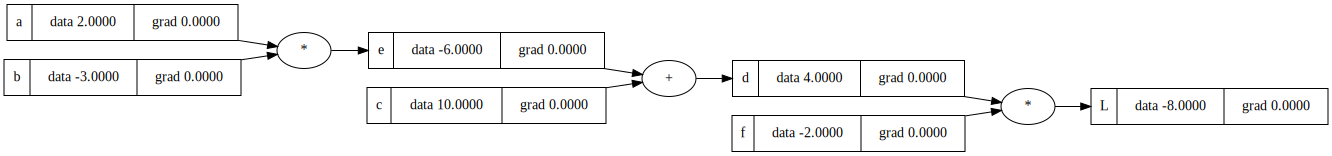

In [152]:
draw_dot(L)

In [153]:
def lol():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0+h, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    return (L2 - L1)/h

In [154]:
lol()

3.9999999999995595

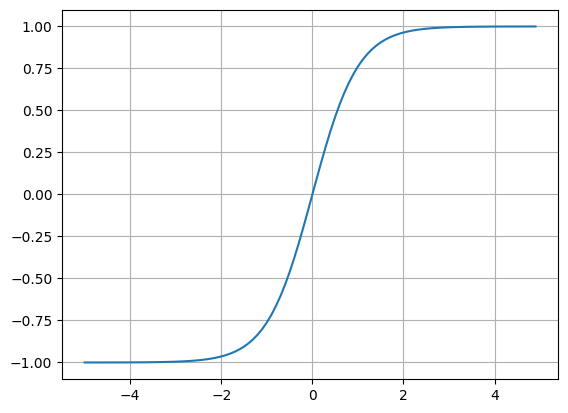

In [155]:
plt.plot(np.arange(-5,5,0.1), np.tanh(np.arange(-5,5,0.1))); plt.grid()

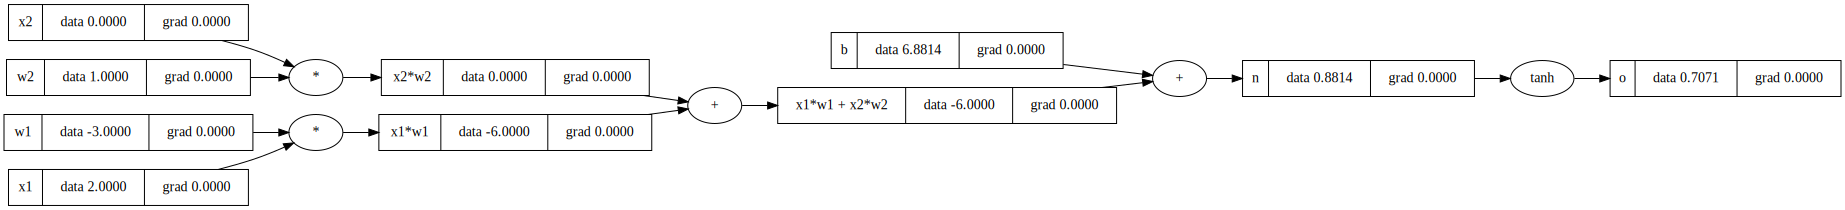

In [156]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label='o'

draw_dot(o)

In [157]:
o.grad = 1.0
o._backward()

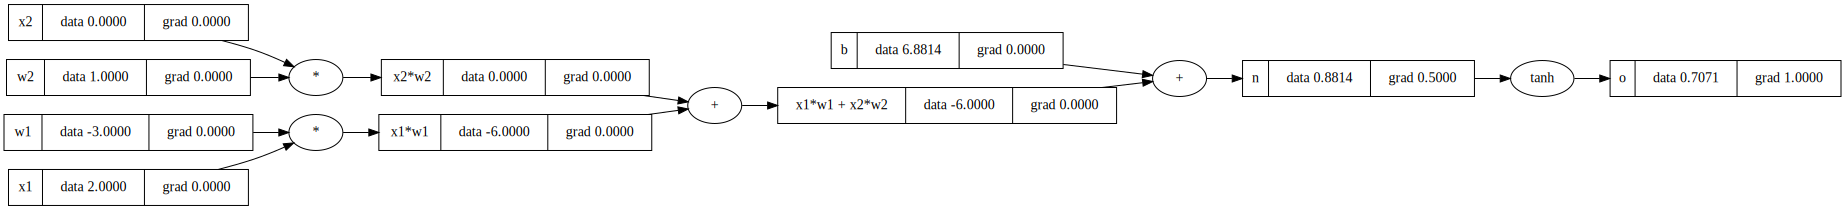

In [158]:
draw_dot(o)

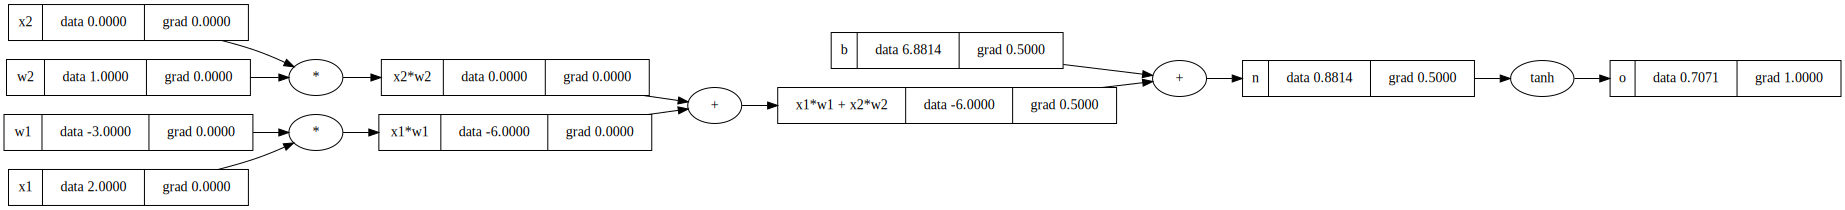

In [159]:
n._backward()
draw_dot(o)

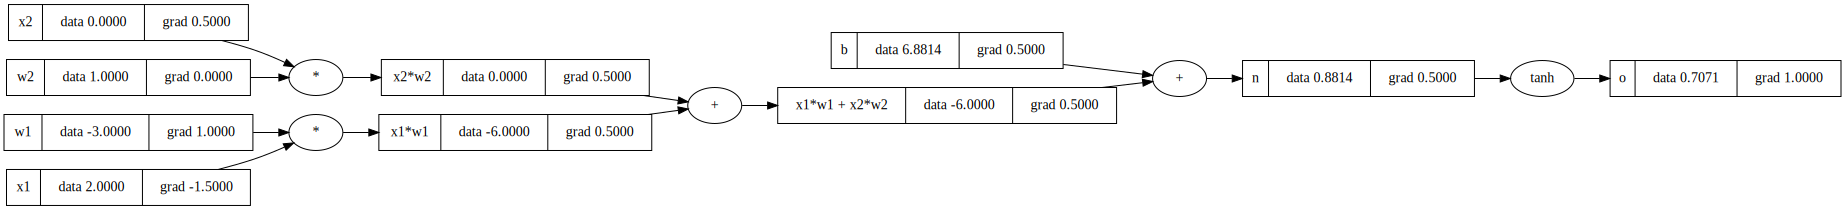

In [160]:
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
draw_dot(o)

In [161]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

for node in reversed(topo):
    node._backward()

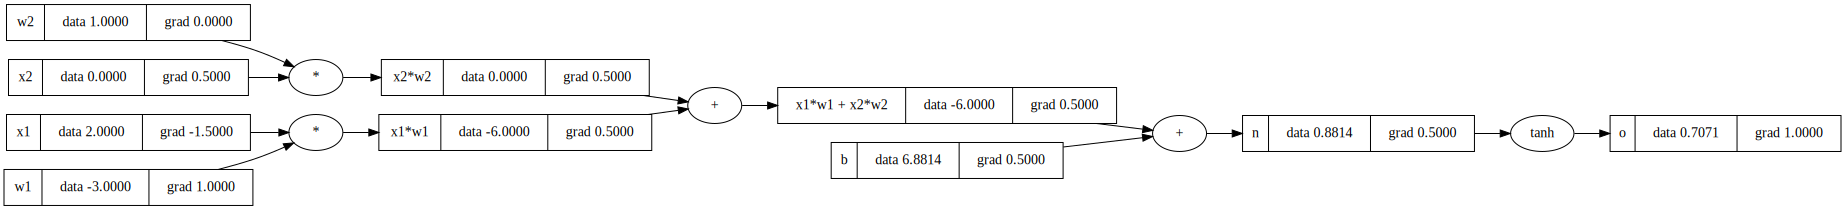

In [162]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label='o'

o.backward()

draw_dot(o)

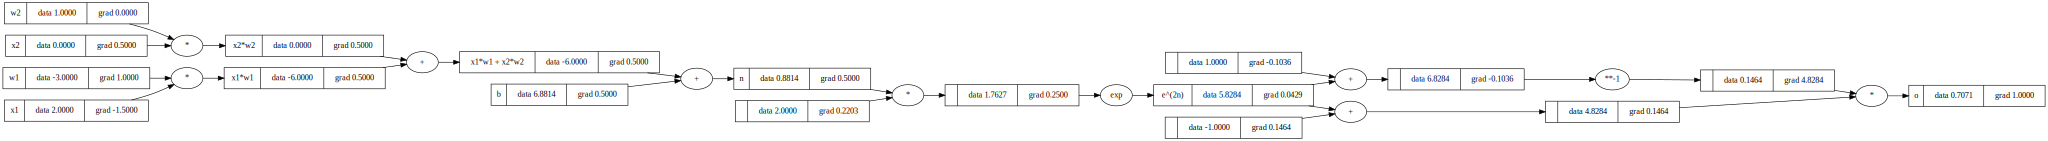

In [163]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp(); e.label = 'e^(2n)'

o = (e-1)/(e+1); o.label='o'

o.backward()

draw_dot(o)

In [164]:
import torch

In [165]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [166]:
o.data.item()

0.7071066904050358

In [167]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1,1))

    def __call__(self, x):
        act = sum(map(lambda a : a[0]*a[1],zip(self.w,x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = list(map(lambda a : a(x),self.neurons))
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sizes = [nin] + nouts
        self.layers = [Layer(sizes[i],sizes[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.28045871423716934)

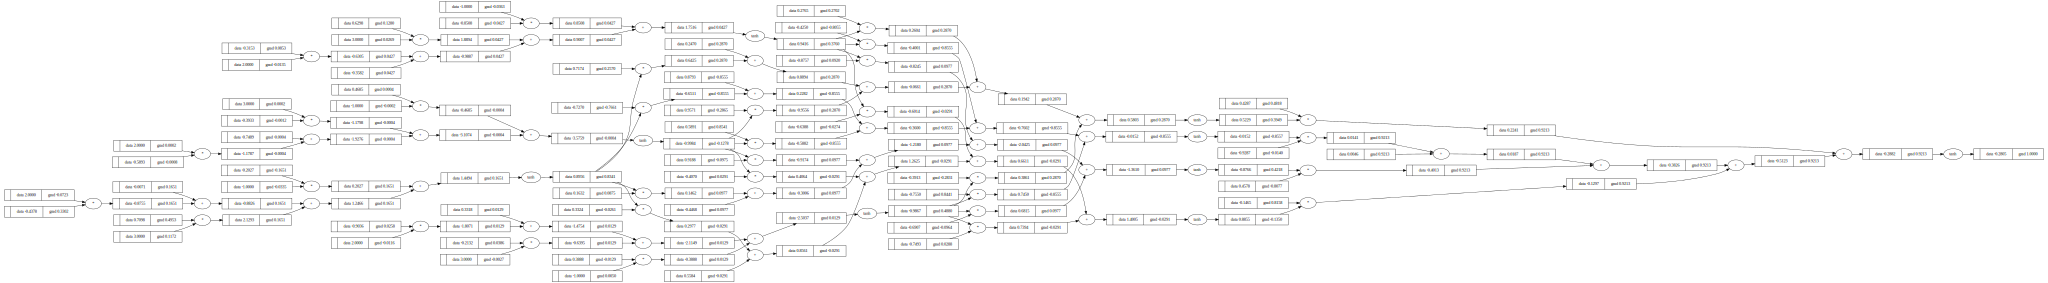

In [168]:
output = n(x)
output.backward()
draw_dot(output)

In [169]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = list(map(n, xs))
ypred

[Value(data=-0.28045871423716934),
 Value(data=-0.882481221052453),
 Value(data=-0.7399534996878231),
 Value(data=-0.6352938883480324)]

In [170]:
loss = sum(map(lambda a : (a[0] - a[1])**2, zip(ys,ypred)))

In [171]:
loss.backward()

In [172]:
learning_rate = 0.01
while loss.data > 0.001:

    ypred = list(map(n, xs))
    loss = sum(map(lambda a : (a[0] - a[1])**2, zip(ys,ypred)))
    print(loss)

    loss.backward()
    for param in n.parameters():
        param.data -= learning_rate * param.grad

Value(data=2.75562094699836)
Value(data=2.313314629396926)
Value(data=1.5009543814975042)
Value(data=0.8369058078290814)
Value(data=0.8167590424073183)
Value(data=0.9582681656616665)
Value(data=0.8705316895020113)
Value(data=0.5278732148793214)
Value(data=0.2183282158185505)
Value(data=0.0838012561756267)
Value(data=0.03714195504548725)
Value(data=0.018928564918995656)
Value(data=0.01046556372815821)
Value(data=0.006041755744389757)
Value(data=0.0035729992297951715)
Value(data=0.0021449885369405793)
Value(data=0.0013013914242765673)
Value(data=0.0007961171186852499)


In [173]:
ypred

[Value(data=0.9897281879840572),
 Value(data=-0.9812866967089585),
 Value(data=-0.9819633043258669),
 Value(data=0.9890178778106664)]